In [1]:
import pandas as pd
import category_encoders
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold

from tqdm import tqdm
from scipy.stats import zscore
import numpy as np
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.ensemble import IsolationForest

In [35]:
def basic_data_processing():
    train = pd.read_csv('./train.csv')
    test = pd.read_csv('./test.csv')
    
    train['총주차대수'] = train['총주차대수'].fillna(0)
    test['총주차대수'] = test['총주차대수'].fillna(0)
    
    train['year'] = pd.to_datetime(train['게재일']).dt.year
    train['month'] = pd.to_datetime(train['게재일']).dt.month
    test['year'] = pd.to_datetime(test['게재일']).dt.year
    test['month'] = pd.to_datetime(test['게재일']).dt.month
#     train['day'] = pd.to_datetime(train['게재일']).dt.day
#     test['day'] = pd.to_datetime(test['게재일']).dt.day
    train = train.drop(['ID','게재일'],axis=1)
    test = test.drop(['ID','게재일'],axis=1)
    train['총층'] = train['총층'].fillna(1)
    test['총층'] = test['총층'].fillna(1)
    train['방수'] = train['방수'].fillna(0)
    test['방수'] = test['방수'].fillna(0)
    
    train['전용면적'] = train['전용면적'].fillna(15)
    test['전용면적'] = test['전용면적'].fillna(15)
    
    str_cols = ['총주차대수','해당층','욕실수']
    for col in str_cols:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)

    str_cols = ['중개사무소','제공플랫폼','매물확인방식','방향','주차가능여부']
    for col in str_cols:
        encoder = category_encoders.TargetEncoder(cols=[col],smoothing=2,min_samples_leaf=5)
        train[col] = encoder.fit(train[col],train['허위매물여부'])
        train[col] = encoder.transform(train[col])
        test[col] = encoder.transform(test[col])
        
        encoder = OneHotEncoder(sparse_output=False)
#     str_cols = ['매물확인방식','방향','주차가능여부']
#     for col in str_cols:
#         encoder = OneHotEncoder(sparse_output=False)
#         encoded = encoder.fit(train[[col]])
#         train = pd.concat([train,pd.DataFrame(encoder.transform(train[[col]]),columns=encoder.get_feature_names_out())],axis=1)
#         test = pd.concat([test,pd.DataFrame(encoder.transform(test[[col]]),columns=encoder.get_feature_names_out())],axis=1)
#         train = train.drop(col,axis=1)
#         test = test.drop(col,axis=1)
    return train, test

In [36]:
train, test = basic_data_processing()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매물확인방식  2452 non-null   float64
 1   보증금     2452 non-null   float64
 2   월세      2452 non-null   int64  
 3   전용면적    2452 non-null   float64
 4   해당층     2452 non-null   float64
 5   총층      2452 non-null   float64
 6   방향      2452 non-null   float64
 7   방수      2452 non-null   float64
 8   욕실수     2452 non-null   float64
 9   주차가능여부  2452 non-null   float64
 10  총주차대수   2452 non-null   float64
 11  관리비     2452 non-null   int64  
 12  중개사무소   2452 non-null   float64
 13  제공플랫폼   2452 non-null   float64
 14  허위매물여부  2452 non-null   int64  
 15  year    2452 non-null   int64  
 16  month   2452 non-null   int64  
dtypes: float64(12), int64(5)
memory usage: 325.8 KB


In [37]:
train1 = train[train.isna().any(axis=1)]
train2 = train.dropna()

test1 = test[test.isna().any(axis=1)]
test2 = test.dropna()

In [38]:
sum(train[train['전용면적'] == 0]['허위매물여부'])/len(train[train['전용면적'] == 0])

ZeroDivisionError: division by zero

C:\Users\User\AppData\Local\Temp\ipykernel_21820\3162293437.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['전용면적'])


<Axes: xlabel='전용면적', ylabel='Density'>

C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\envs\project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\envs\project\lib\site-packa

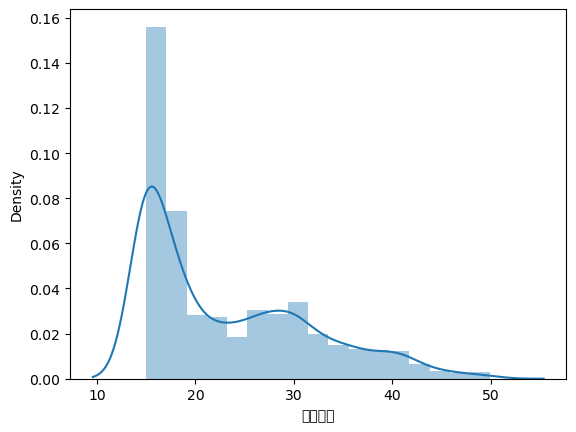

In [39]:
sns.distplot(train['전용면적'])

In [29]:
train, test = basic_data_processing()

train1 = train[train.isna().any(axis=1)]
train2 = train.dropna()

test1 = test[test.isna().any(axis=1)]
test2 = test.dropna()


train = train1
test = test1
target = '허위매물여부'
cut_ratio = 0.0
test_size = 0.2
cv = 10

X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[[target]], test_size=test_size, stratify=train[[target]], random_state=42)

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 각 모델의 feature importance를 얻습니다.
lgbm_importance = lgbm.feature_importances_
xgb_importance = xgb.feature_importances_
catboost_importance = catboost.feature_importances_

# 각 모델의 feature importance를 합산합니다.
total_importance = lgbm_importance + xgb_importance + catboost_importance
total_importance = xgb_importance

# 중요도를 기준으로 상위 90%의 피쳐를 유지
threshold = np.percentile(total_importance, cut_ratio*100)
selected_features = X_train.columns[total_importance >= threshold]

# 유지된 피쳐를 기반으로 데이터를 업데이트
X_train = X_train[selected_features]
X_test = X_test[selected_features]
test = test[selected_features]

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42, max_depth=8)
xgb = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=8, n_estimators=100)
catboost = CatBoostClassifier(random_state=42, max_depth=8, verbose=0)
# rf = RandomForestClassifier(random_state=42, oob_score=True)
# iso = IsolationForest(random_state=42, contamination=0.11)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)
# iso.fit(X_train, y_train)

# 소프트 보팅 앙상블 모델 생성
ensemble_model = VotingClassifier(estimators=[
   ('lgbm', lgbm),
    ('xgb', xgb),
    ('catboost', catboost),
#    ('rf', rf)
], voting='soft')

# Cross validation을 위한 StratifiedKFold 사용
# cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
cv = KFold(n_splits=cv, shuffle=True, random_state=0)

# f1_score를 평가 지표로 사용
scorer = make_scorer(f1_score, average='macro')

# 각 모델과 앙상블 모델에 대해 cross validation 수행
lgbm_cv_scores = cross_val_score(lgbm, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
xgb_cv_scores = cross_val_score(xgb, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
catboost_cv_scores = cross_val_score(catboost, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
# rf_cv_scores = cross_val_score(rf, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
ensemble_cv_scores = cross_val_score(ensemble_model, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
# iso_cv_scores = cross_val_score(iso, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)

# 결과 출력
print(f"LGBM Cross Validation Macro F1 Scores: {np.mean(lgbm_cv_scores)}")
print(f"XGBoost Cross Validation Macro F1 Scores: {np.mean(xgb_cv_scores)}")
print(f"CatBoost Cross Validation Macro F1 Scores: {np.mean(catboost_cv_scores)}")
# print(f"RamdomForest Cross Validation Macro F1 Scores: {np.mean(rf_cv_scores)}")
print(f"Ensemble Model Cross Validation Macro F1 Scores: {np.mean(ensemble_cv_scores)}")
# print(f"iso Model Cross Validation Macro F1 Scores: {np.mean(iso_cv_scores)}")


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [40]:
train, test = basic_data_processing()

train1 = train[train.isna().any(axis=1)]
train2 = train.dropna()

test1 = test[test.isna().any(axis=1)]
test2 = test.dropna()


train = train2
test = test2
target = '허위매물여부'
cut_ratio = 0.1
test_size = 0.2
cv = 10

X_train, X_test, y_train, y_test = train_test_split(train.drop(target,axis=1), train[[target]], test_size=test_size, stratify=train[[target]], random_state=42)

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# 각 모델의 feature importance를 얻습니다.
lgbm_importance = lgbm.feature_importances_
xgb_importance = xgb.feature_importances_
catboost_importance = catboost.feature_importances_

# 각 모델의 feature importance를 합산합니다.
total_importance = lgbm_importance + xgb_importance + catboost_importance
total_importance = xgb_importance

# 중요도를 기준으로 상위 90%의 피쳐를 유지
threshold = np.percentile(total_importance, cut_ratio*100)
selected_features = X_train.columns[total_importance >= threshold]

# 유지된 피쳐를 기반으로 데이터를 업데이트
X_train = X_train[selected_features]
X_test = X_test[selected_features]
test = test[selected_features]

# 각 모델을 초기화합니다. (실제 데이터에 맞게 설정 필요)
lgbm = LGBMClassifier(random_state=42, max_depth=8)
xgb = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=8, n_estimators=100)
catboost = CatBoostClassifier(random_state=42, max_depth=8, verbose=0)
# rf = RandomForestClassifier(random_state=42, oob_score=True)
# iso = IsolationForest(random_state=42, contamination=0.11)

# 각 모델을 훈련합니다. (실제 데이터에 맞게 설정 필요)
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)
catboost.fit(X_train, y_train)
# iso.fit(X_train, y_train)

# 소프트 보팅 앙상블 모델 생성
ensemble_model = VotingClassifier(estimators=[
   ('lgbm', lgbm),
    ('xgb', xgb),
    ('catboost', catboost),
#    ('rf', rf)
], voting='soft')

# Cross validation을 위한 StratifiedKFold 사용
# cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=0)
cv = KFold(n_splits=cv, shuffle=True, random_state=0)

# f1_score를 평가 지표로 사용
scorer = make_scorer(f1_score, average='macro')

# 각 모델과 앙상블 모델에 대해 cross validation 수행
lgbm_cv_scores = cross_val_score(lgbm, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
xgb_cv_scores = cross_val_score(xgb, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
catboost_cv_scores = cross_val_score(catboost, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
# rf_cv_scores = cross_val_score(rf, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
ensemble_cv_scores = cross_val_score(ensemble_model, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)
# iso_cv_scores = cross_val_score(iso, X_test, y_test, cv=cv, scoring=scorer, n_jobs=-1)

# 결과 출력
print(f"LGBM Cross Validation Macro F1 Scores: {np.mean(lgbm_cv_scores)}")
print(f"XGBoost Cross Validation Macro F1 Scores: {np.mean(xgb_cv_scores)}")
print(f"CatBoost Cross Validation Macro F1 Scores: {np.mean(catboost_cv_scores)}")
# print(f"RamdomForest Cross Validation Macro F1 Scores: {np.mean(rf_cv_scores)}")
print(f"Ensemble Model Cross Validation Macro F1 Scores: {np.mean(ensemble_cv_scores)}")
# print(f"iso Model Cross Validation Macro F1 Scores: {np.mean(iso_cv_scores)}")


C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\envs\project\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y

LGBM Cross Validation Macro F1 Scores: 0.8290769870741791
XGBoost Cross Validation Macro F1 Scores: 0.8174888341954654
CatBoost Cross Validation Macro F1 Scores: 0.798559140069693
Ensemble Model Cross Validation Macro F1 Scores: 0.8201164771323372


In [112]:
lgb_pred = [i[1] for i in lgbm.predict_proba(test)]
xgb_pred = [i[1] for i in xgb.predict_proba(test)]
cat_pred = [i[1] for i in catboost.predict_proba(test)]

sub = pd.read_csv('./sample_submission.csv')
l,x,c = 0.3,0.3,0.4
threshold = 0.25
pred = [l*lgb_pred[i] + x*xgb_pred[i] + c*cat_pred[i] for i in range(len(sub))]
print('Train ratio:',len(train[train['허위매물여부'] == 1])/len(train))
print('Prediction answer ratio:',len([i for i in pred if i > threshold])/len(pred))

answer = []
for p in pred:
    if p > threshold:
        answer.append(1)
    else:
        answer.append(0)

sub['허위매물여부'] = answer
sub.to_csv('./answer.csv',index=False)

Train ratio: 0.12153344208809136
Prediction answer ratio: 0.10603588907014681


In [154]:
iso_pred = iso.predict(test)
sub = pd.read_csv('./sample_submission.csv')

for i in range(len(iso_pred)):
    if iso_pred[i] == -1:
        iso_pred[i] = 0

print('Train ratio:',len(train[train['허위매물여부'] == 1])/len(train))
print('Prediction answer ratio:',1-sum(iso_pred)/len(sub))



sub['허위매물여부'] = iso_pred
sub.to_csv('./answer.csv',index=False)

Train ratio: 0.12153344208809136
Prediction answer ratio: 0.09135399673735722


# ranked
test 0.2
cv 10
threshold 0.25
lgb 1, xgb 0, cat 0

C:\Users\User\AppData\Local\Temp\ipykernel_27756\2016596573.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred)


<Axes: ylabel='Density'>

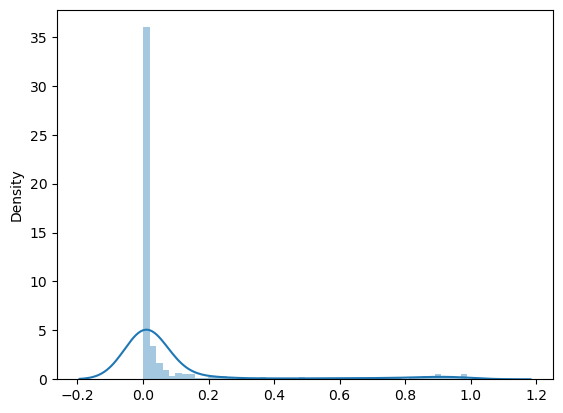

In [116]:
sns.distplot(pred)